# Lecture 3: Numerical Python
## September 06, 2024

## Functions as arguments

Like all objects, functions can be arguments to functions

In [14]:
def add(x,y):
    return x+y

def sub(x, y):
    return x-y

def apply(func, x, y):
    return func(x, y)

In [15]:
apply(add, 1, 2)

3

In [16]:
apply(sub, 7, 5)

2

## Functions inside functions

Python allows nested function definitions:

In [17]:
def g(x, y):
    
    def cube(x):
        return x*x*x
    
    return y*cube(x)

g(4, 6)


384

## Function returning functions

In [18]:
def h():
    pi = 0.13
    def inner_h():
        print("Inside inner_h but can access pi={}".format(pi))
        
    return inner_h

foo = h()
foo

<function __main__.h.<locals>.inner_h()>

In [19]:
foo()

Inside inner_h but can access pi=0.13


## More functions returning functions: *decorators*

A toy example

In [20]:

def foo():
    return 1

def bar():
    return 5

def outer(func):
    def inner():
        print("before calling function")
        return func() + 100
    return inner

foo = outer(foo)

The function `decorated` is a decorated version of function `foo`.
It is `foo` plus something more:

In [21]:
foo()

before calling function


101

To simplify, we could just write
```python 
foo = outer(foo)
```
to replace foo with its decorated version each time it is called

## The `@decorator` syntax

Python provides a short notation for decorating a function with
another function:

In [22]:
def outer(func):
    def inner():
        print("before calling function")
        return func() + 100
    return inner

def bar():
    return 1

@outer
def foo():
    return 1


In [23]:
bar()

1

In [24]:
foo()

before calling function


101

In [25]:
from math import log
def g(x):
    return log(x) - 2

g(0)

ValueError: math domain error

In [26]:
from math import log

def checkrange(func):
    def inner(x):
        if x <= 0:
            print("Error: x must be larger than zero")
        else:
            return func(x)
    return inner

@checkrange
def g(x):
    return log(x) - 2


In [27]:
g(-1)

Error: x must be larger than zero


This is essentially the same as writing `g = checkrange(g)`.

A decorator is simply a function taking a function as input
and returning another function. 

The syntax `@decorator` is a
short-cut for the more explicit `f = decorator(f)`.

## A (much) more useful decorator: memoization

The first time we learned multiplication, our strategy might to add cumulatively: e.g. 3x3 = 3 + 3 + 3 = 6 + 3 = 9

In [28]:
from time import sleep

def slow_mult(x,y):
    res = 0
    for i in range(y):
        print("Thinking...")
        sleep(1)
        res += x
    return res

print(slow_mult(3,3))
print(slow_mult(3,3))

Thinking...
Thinking...
Thinking...
9
Thinking...
Thinking...
Thinking...
9


We call the function with the same input arguments, and hence perform the same (slow) calculations multiple times.

The idea of memoization (or buffering) is to buffer the input-output pairs for which the function was called.
If the function is called twice with same input arguments, we return the buffer value.

The implementation of a memoization with a `decorator` could look like:

In [29]:

def memoize(func):
    ''' Caches a function's return value each time it is called.
        If called later with the same arguments, the cached value is returned
        (not reevaluated). '''
    cache = {}  # Stores all input-output pairs

    def inner(x, y):
        if (x, y) in cache:
            return cache[(x, y)]
        else:
            result = func(x, y)
            cache[(x, y)] = result
            return result
        
    return inner

Now we can apply the decorator to our slow function. Demo:

In [30]:
@memoize
def slow_mult(x, y):
    res = 0
    for i in range(y):
        print("Thinking...")
        sleep(1)
        res += x
    return res

... and test it out

In [31]:
slow_mult(3, 3)

Thinking...
Thinking...
Thinking...


9

# Numerical computations with NumPy


## Python can be slow for numerical computations

Python scripts are first compiled to byte-code.

The byte-code is then *interpreted*.

Text processing is usually as fast as in C.

Loops over large data structures might be very slow:
```Python
for i in range(len(A)):
    A[i] = ...
```    

Fortran, C and C++ compilers are good at optimizing such loops at compile time and produce very efficient assembly code (e.g. 100 times faster).

Fortunately, long loops in scripts can easily be migrated to Fortran or C.

## With NumPy, Python scripts may be fast enough

Read 100 000 (x,y) data from file and write (x,f(y)) out again

* Pure Python: 4s
* Pure Perl: 3s
* Pure Tcl: 11s
* Pure C (fscanf/fprintf): 1s
* Pure C++ (iostream): 3.6s
* Pure C++ (buffered streams): 2.5s
* Python using NumPy module: 2.2s (!)


Remark: in practice, 100 000 data points are written and read in binary format, resulting in much smaller differences

## NumPy enables efficient numerical computing in Python

Why efficient?

* Offers efficient arrays (contiguous storage) with associated array operations 
* Written in C and Fortran

NumPy is the *de facto* standard in Python,
and today even is part of interoperability with other languages (R, Julia, etc.).


## Contents

* A first taste of NumPy
* Creating arrays
* Indexing/slicing arrays
* Random numbers
* Structured arrays
* Performance considerations
* Linear algebra
* Plotting

## More info

* The NumPy quickstart (https://docs.scipy.org/doc/numpy/user/quickstart.html)
* Scientific Computing Tools for Python 
  (https://www.scipy.org)
* Scipy Lecture Notes (https://scipy-lectures.org)

## A taste of NumPy

**Task**: Fit a line through a set of (x, y) data points

In [32]:
# Only needed for Jupyter
%matplotlib inline

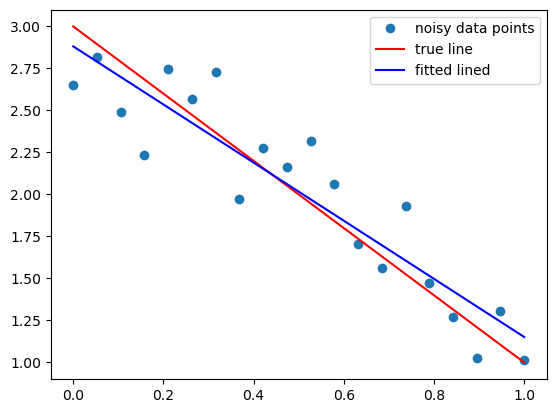

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Create the x and y datapoints
N = 20
x = np.linspace(0.0, 1.0, N)  # coordinates
y_line = -2 * x + 3  # Create y values for the datapoints
y = y_line + np.random.normal(0, 0.25, N)  # add noise

# create and solve least squares system:
A = np.array([x, np.ones(N)])
A = A.transpose()
result = np.linalg.lstsq(A, y, rcond=None)

# result is a 4-tuple, the solution (a,b) is the 1st entry:
a, b = result[0]

# plot the result
plt.plot(x, y, "o", label="noisy data points")
plt.plot(x, y_line, "r", label="true line")
plt.plot(x, a * x + b, "b", label="fitted lined")

plt.legend()
plt.savefig("myplot.pdf")
plt.show()

## The example, step by step (i): Import NumPy module

Importing the `numpy` module (abbreviated as `np` for simple use):

In [34]:
import numpy as np

## The example, step by step (ii): Create noisy data

**Goal**: Create $N$ datapoints that satisfy the equation:

$$y = -2x + 3,$$

and add some white noise to the y values.

**Step 1**: Create an equivally distributed array with x coordinates:

In [35]:
# Create the x and y datapoints
N = 21                                  
x = np.linspace(0.0, 1.0, N)               # coordinates
x

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

**Step 2**: Generate the y data points using the equation above:

In [36]:
y_line = -2 * x + 3  # Create y values for the datapoints
plt.plot(x, y_line);

**Note**: numpy performs operation elementwise (in contrast to Python lists).

In [37]:
regular_list = [1, 2, 3]
numpy_list = np.array([1, 2, 3])

print(regular_list * 5)
print(numpy_list * 5)

[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]
[ 5 10 15]


**Step 3:** Add noise:

In [38]:
y = y_line + np.random.normal(0, 0.25, N)  # add noise
plt.plot(x, y);

## The example, step by step (iii): Fit the line through the data

**Task**: Identify the two line parameters $a, b$ such that

$$y \approx a x + b$$
for all x, y data points.

More precisely, we want to identify the line where the **summed squared error is minimal**:

$$\min_{a, b} \sum_{i=0}^N |y_i - ax_i - b|^2$$

numpy has a built in function for solving **least squares** problems: `numpy.linalg.lstsq`:

In [39]:
help(np.linalg.lstsq)

Help on _ArrayFunctionDispatcher in module numpy.linalg:

lstsq(a, b, rcond='warn')
    Return the least-squares solution to a linear matrix equation.

    Computes the vector `x` that approximately solves the equation
    ``a @ x = b``. The equation may be under-, well-, or over-determined
    (i.e., the number of linearly independent rows of `a` can be less than,
    equal to, or greater than its number of linearly independent columns).
    If `a` is square and of full rank, then `x` (but for round-off error)
    is the "exact" solution of the equation. Else, `x` minimizes the
    Euclidean 2-norm :math:`||b - ax||`. If there are multiple minimizing
    solutions, the one with the smallest 2-norm :math:`||x||` is returned.

    Parameters
    ----------
    a : (M, N) array_like
        "Coefficient" matrix.
    b : {(M,), (M, K)} array_like
        Ordinate or "dependent variable" values. If `b` is two-dimensional,
        the least-squares solution is calculated for each of the `K`

In [40]:
A = np.array([x, np.ones(N)])
A = A.transpose()
result = np.linalg.lstsq(A, y, rcond=None)
result

(array([-1.8573413 ,  2.96653039]),
 array([1.31336576]),
 2,
 array([5.16319707, 1.23142031]))

In [41]:
a, b = result[0]
a, b

(-1.8573413016820863, 2.9665303877888887)

Now:
* `a` contains the steepness (gradient) of the line.
* `b` contains the offset of the line at `x=0`.

Our line approximate is therefore:
```python
 y = a * x + b
 ```
 
 The correct values are $a=-2$ and $b=3$. Let's check what we get:

In [42]:
print(f"a = {a}")
print(f"b = {b}")

a = -1.8573413016820863
b = 2.9665303877888887


## The example, step by step (iv): Plot the results

Use the [matplotlib](https://matplotlib.org) library to plot the result:

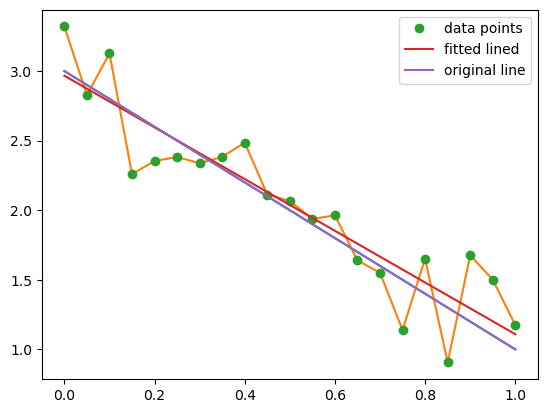

In [43]:
import matplotlib.pyplot as plt

plt.plot(x, y, "o", label="data points")
plt.plot(x, a * x + b, label="fitted lined")
plt.plot(x, y_line, label="original line")
plt.legend()
plt.show()

## Exercise

1) Create x-values of n uniformly distributed points between 0 and 10 (choose n yourself)

2) Create corresponding y-values given by y = 2*x

3) Plot x versus y with matplotlib.

4) Create a new set of y values given by y = exp(-0.3*x) (hint: exp might need to be imported).

5) Add random noise to the y-values. hint: use the numpy random module

6) Plot x versus y, and also plot x versus y with noise

7) Use the y-values with added noise as data points. Run a exponential regression to find the best parameters for an exponential fit of the data. hint: polyfit


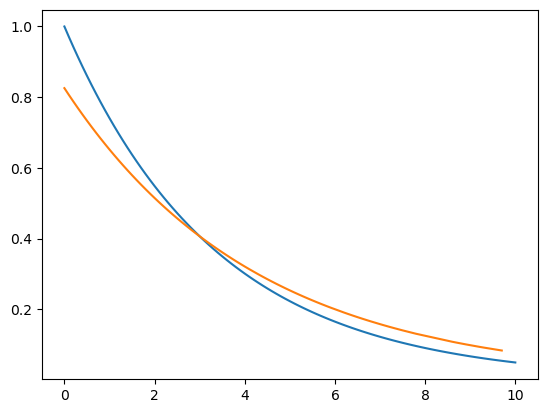

In [44]:
import numpy as np
import matplotlib.pyplot as plt
n = 101
x = np.linspace(0,10,n)
y_exp = np.exp(-0.3*x)
y_noise = y_exp + 0.7*(np.random.random(n)-0.5)

max_noise = y_exp
condition = (y_noise - max_noise)
X = x[y_noise>0]
y_noise = y_noise[y_noise>0]




y_noise_log = np.log(y_noise)
data = np.polyfit(X,y_noise_log,deg=1)

logy = data[1] + data[0]*X
plt.plot(x, y_exp, X, np.exp(logy))
plt.show()


# Numpy arrays


The most basic array type that NumPy provides is `ndarray`. These are N-dimensional homogenous collections of "items" of the same type.

```python
np.array([5., 10., 11.])
np.array(["a", "b", "c"])
```

**Properties**:

1. Arrays have a fixed size.
2. Arrays have one associated data type. 
3. *Contents* of arrays are mutable (values in array can be changed)

## Creating NumPy arrays

Numpy provides convenience functions for creating common arrays:

In [45]:
np.zeros(3)

array([0., 0., 0.])

In [46]:
np.ones((3, 2))

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [47]:
np.empty((2, 2)) # uninitialised array. Might contain arbitrary data

array([[ 80. ,  52.8],
       [576. , 422.4]])

## Array with a sequence of numbers


### linspace
`linspace(a, b, n)` generates `n` uniformly spaced
coordinates, starting with `a` and ending with `b`

<img src="figs/numpy-linspace.png" style="width: 500px;"/>

Use `endpoint=False` to exclude the last point (matches `range(start, stop)`)

In [48]:
np.linspace(-3, 2, num=5)

array([-3.  , -1.75, -0.5 ,  0.75,  2.  ])

In [49]:
np.linspace(-3, 2, num=5, endpoint=False)

array([-3., -2., -1.,  0.,  1.])

### arange

`arange` is the numpy equivalent of Python's `range`

In [50]:
np.arange(-5, 6, step=1, dtype=float)

array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.])

## Warning: `arange` can give unexpected results

`arange`'s upper limit may or may not be included!

Compare this examples:

In [51]:
np.arange(8.2, 8.2+0.05, 0.05)  # OK!

array([8.2 , 8.25])

with this one:

In [52]:
np.arange(8.2, 8.2+0.1, 0.05)   # Not OK?

array([8.2 , 8.25])

**What is happening?**

**Reason**: An accumulated round-off error in the second case:

In [53]:
8.2 + 0.05

8.25

In [54]:
8.2 + 0.1

8.299999999999999

# Array attributes

## Important array attributes

Given an array `a`, you have access to some useful attributes:

|Attribute|Description|
|--|-------------------------------|
|*a.data* |Buffer to raw data|
|*a.dtype*|Type information of data|
|*a.ndim* |Number of dimensions|
|*a.shape*|Tuple representing rank of array in each direction|
|*a.size* |Total number of elements|
|*a.nbytes* |Total number of bytes allocated for array|

**Example**: given an array a, make a new array `x` of same dimension and data type:

In [55]:
np.zeros(A.shape, A.dtype)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [56]:
np.zeros_like(A)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

## dtypes: the type of the arrays elements

Use the `dtype` argument to create an array of a specific type:
```python
np.zeros(3, dtype=np.int)       # integer datatype
np.ones(3, dtype=np.float32)    # single precision
np.ones(3, dtype=np.float64)    # double precision
np.array(3, dtype=np.complex)   # complex numbers
```
A full list of valid types can be found [here: https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html).

## **By default**, numpy arrays will automatically select a suitable type to store the elements:

The type of the array is automatically determined:

Array of integers:

```python
np.array([1, 2, 3])
```

Array of floats:
```python
np.array([1.0, 2, 3]) 
```
Array of automatically converted strings:
```python
np.array([1.0, 2, "a"])  # array of strings  of dtype "<U32" (unicode strings with max 32 characters.)
```

# More constructions of numpy arrays

## Python lists and numpy arrays

### From list to array
`array(list, [datatype])` generates a numpy.array from a list:

In [57]:
mylist = [0, 1.2, 4, -9.1, 5, 8]
a = np.array(mylist)

### From array to list

In [58]:
a.tolist()

[0.0, 1.2, 4.0, -9.1, 5.0, 8.0]

## From "anything" to NumPy array

```python
asarray(a)
```

converts "any" object `a` to a NumPy array if possible/necessary, tries to avoid copying.

Works with int's, list's, tuple's, numpy.array's, ...,


**Example**: Use asarray to allow flexible arguments in functions:

In [59]:
def myfunc(some_sequence):
    a = np.asarray(some_sequence)
    return 3 * a - 5


for input_item in (
    [1, 2, 3],  # list argument
    np.zeros(10), # array
    -4.5, # float
    6, # int
):
    print(input_item, type(input_item), ":")
    print("   3 * a - 5 =", myfunc(input_item))


[1, 2, 3] <class 'list'> :
   3 * a - 5 = [-2  1  4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] <class 'numpy.ndarray'> :
   3 * a - 5 = [-5. -5. -5. -5. -5. -5. -5. -5. -5. -5.]
-4.5 <class 'float'> :
   3 * a - 5 = -18.5
6 <class 'int'> :
   3 * a - 5 = 13


# Higher-dimensional arrays

## Creating higher-dimensional arrays

Passing a tuple to an array constructor results in a higher-dimensional array:

In [60]:
np.zeros((2, 3, 3))     # 2*3*3 dim. array

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

A two-dimensional array from two one-dimensional Python lists:

In [61]:
x = [0, 0.5, 1]
y = [-6.1, -2, 1.2]  # Python lists
np.array([x, y])        # form array with x and y as rows

array([[ 0. ,  0.5,  1. ],
       [-6.1, -2. ,  1.2]])

Numpy allows up to 32 dimensions. You can retrieve the shape of an array with

In [62]:
a = np.zeros((2, 3, 3))
a.shape

(2, 3, 3)

## Changing array dimensions

Use `reshape` to reinterpret the same data as a new shape *without copying* data:

In [63]:
a = np.array([0, 1.2, 4, -9.1, 5, 2])
a

array([ 0. ,  1.2,  4. , -9.1,  5. ,  2. ])

In [64]:
b = a.reshape((2, 3))  # turn a into a 2x3 matrix
b

array([[ 0. ,  1.2,  4. ],
       [-9.1,  5. ,  2. ]])

The reshaped array points to the same data vector, i.e. no data is copied:

In [65]:
b[0,0]

0.0

In [66]:
b[0,0] = -10
print(f"a = {a}")
print(f"b = \n{b}")


a = [-10.    1.2   4.   -9.1   5.    2. ]
b = 
[[-10.    1.2   4. ]
 [ -9.1   5.    2. ]]


## NumPy data ordering

Numpy allows to store array in *C* or *FORTRAN* ordering:

**Note**: For one-dimensional arrays, the orders are equivalent.

The order can be chosen with the `order` flag:

In [67]:
a = np.asarray([[1, 2], [3, 4]], order='F')  # Fortran order
a.flags                       # Check if Fortran ordering is used

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

## NumPy data ordering (2)

Numpy automatically converts the ordering when necessary:

In [68]:
A = np.array([[1, 2], [3, 4]], order="C")
B = np.array([[1, 2], [3, 4]], order="F")
print(A + B)

[[2 4]
 [6 8]]


Transposing a matrix is perfomed by swapping the ordering (without data copying):

In [69]:
A.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [70]:
B.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [71]:
A.transpose().flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

# Array indexing

## Basic indexing

The indicing syntax that we are know from list's also work for array's.

### Getting values
Slicing:
```python
a[1:4]           # Get 2nd to 4th element
```
Fancy indexing:
```python
a[[0, 2, 3]]     # Get entries 0, 2 and 3
```
**Important**: Slicing returns a *view* to the original array, i.e. no data is copied. Fancy indexing always returns a copy of the array.

### Setting values
```python
a[2:4] = -1      # set a[2] and a[3] equal to -1
a[-1]  = a[0]    # set last equal to first element
a[:]   = 0       # set all elements of a equal to 0
```

## Multi-dimensional indexing

Multi-dimensional indexing has the same syntax as with list's:
```python
a = ones([2, 3]) # create a 2x3 matrix 
                 # (two rows, three columns)

a[1,2] = 10      # set element (1,2) (2nd row, 3rd column)
a[1][2] = 10     # equivalent syntax (slower)
a[:,2] = 10      # set all elements in 3rd column
a[1,:] = 10      # set all elements in 2nd row
a[:,:] = 10       # set all elements 
```

## Example: extracting sub-matrices with slicing

Given this matrix:

In [72]:
a = np.linspace(0, 29, 30).reshape(5, 6)
print(a)

[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29.]]


we can use slicing to get a *view* of a subset of this matrix.
For example to get the submatrix consisting of row 2 and 3 and every second column, we could use:

In [73]:
a[1:3, ::2] = 0  # a[i,j] for i=1,2 and j=0,2,4

a

array([[ 0.,  1.,  2.,  3.,  4.,  5.],
       [ 0.,  7.,  0.,  9.,  0., 11.],
       [ 0., 13.,  0., 15.,  0., 17.],
       [18., 19., 20., 21., 22., 23.],
       [24., 25., 26., 27., 28., 29.]])

To get the submatrix consisting of every 3rd row, and every second column starting from the third column, we would use:

In [74]:
a[::3, 2::2]  # a[i,j] for i=0,3 and j=2,4

array([[ 2.,  4.],
       [20., 22.]])

## Slices create *views* of array data

Assigning to a sliced array will change the original array:

In [75]:
a = np.ones([3, 2])
b = a[2, :]  # get a view onto the 3rd row
b[0] = np.pi  # assigning to b is reflected in a!
print(a)

[[1.         1.        ]
 [1.         1.        ]
 [3.14159265 1.        ]]


To avoid referencing via slices (if needed) use copy:
```python
b = a[2,:].copy()  # b has its own vector structure
```

**Note**: This behaviour is different to Python `lists`, where `a[:]` makes always a copy

# Loops


## Loops over arrays using indices

If we know the dimension of the array, we can use a nested loop to iterate over all array elements:


In [76]:
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        a[i, j] = (i + 1) * (j + 1) * (j + 2)
        print(f"a[{i}, {j}] = {a[i, j]}")
    print()  # empty line after each row

a[0, 0] = 2.0
a[0, 1] = 6.0

a[1, 0] = 4.0
a[1, 1] = 12.0

a[2, 0] = 6.0
a[2, 1] = 18.0



* Is there a more *Pythonic* way?
* What if we do not know the dimension of the array?

## Better: Use standard Python loops

A standard for loop iterates over the first index. 

**Example:** Looping over each element in a matrix:
```python
for row in a:
    for element in row:
         my_func(element)
```

## For unknown dimensions loop over the flattened array

View array as one-dimensional and iterate over all elements:
```python
for element in a.ravel():
    my_func(element)
```
ravel() returns a *flattened array*, (1D version). Might return a copy if necessary. 

**Advice**: Use `ravel()` only when reading elements, for assigning it is better to use `shape` or `reshape`.

# Numpy Array computations

## Arithmetic operations

Arithmetic operations can be used with arrays:

In [77]:
import numpy as np
from math import sin, exp
a = np.linspace(0, 10, 11)

b = 3 * a - 1
c = np.sin(b)
d = np.exp(c)

print(b,)

[-1.  2.  5.  8. 11. 14. 17. 20. 23. 26. 29.]


**Note**: most arithmetic operations in numpy are performed **elementwise**.

## Array operations are much faster than element-wise operations

Let's compare the array versus element-wise operation on a 10 million large array.

#### Element wise implementation

In [78]:
%%time
import numpy as np

a = np.linspace(0, 1, int(1e07))  # create a large array

b = np.empty_like(a)
for i in range(a.size):
    b[i] = 3 * a[i] - 1

CPU times: total: 2.08 s
Wall time: 2.09 s


Runtime ca 3(?) seconds.

#### Implementation with array operations

In [79]:
%time
b = 3 * a - 1

CPU times: total: 0 ns
Wall time: 0 ns


Runtime ca 0.02(?) seconds!

A ca. 100x speed-up!

# Vectorization user-defined functions

Imagine you have implemented your own function and would like to apply it to all elements in an array:

In [80]:
a = np.linspace(-1, 1, 1000000)


def myfunc(x):
    if x > 0:
        return 0
    else:
        return x ** 2


myfunc(a)  # ??

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

**Problem**: myfunc operates on the entire array instead of elementwise operations.

# Potential solution to vectorization user-defined functions

Loop over each array element and call myfunc 

In [ ]:
%%time
out = np.empty(len(a))

for i, ele in np.ndenumerate(a):
    out[i] = myfunc(ele) 

CPU times: total: 46.9 ms
Wall time: 467 ms


Runtime ca 0.4(?) s

**This is slow**!

# Better solution

Convert myfunc to a *vectorized* function: 

In [ ]:
%%time
vfunc = np.vectorize(myfunc)
out2 = vfunc(a)          

CPU times: total: 31.2 ms
Wall time: 206 ms


Runtime ca 0.1 s

**Much faster**! 

# Plotting with matplotlib

Matplotlib is the most popular package in SciPy for creating publication quality figures. The easiest way to use matplotlib is to import the submodule "pyplot".

## Learning resources

* [Matplotlib tutorial](http://www.labri.fr/perso/nrougier/teaching/matplotlib) by Nicolas P. Rougier
* [The Matplotlib Gallery:](http://matplotlib.org/gallery.html)


# A simple plot


Plotting one, or multiple sets of data is done with:

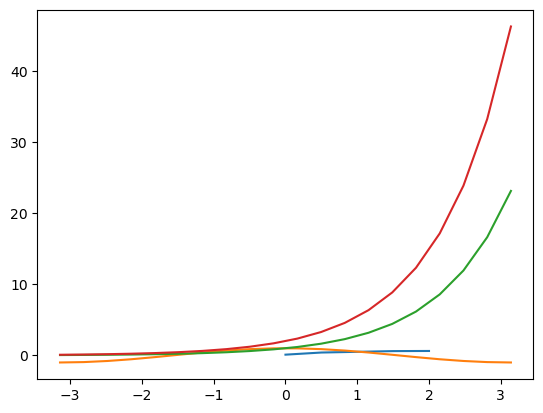

In [82]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(-np.pi, np.pi, 20, endpoint=True)
Y = np.cos(X)
Z = np.exp(X)

plt.plot(X, Y)
plt.plot(X, Z)
plt.plot(X, 2*Z)
plt.show()

# Adjusting your plot


Typical adjustments:
* Change line color, thickness, type
* Change axis settings
* Add labels, legends
* ...

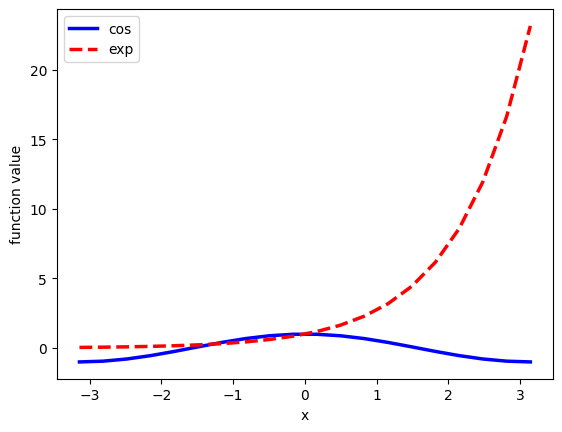

In [ ]:
plt.plot(
    X, Y, label="cos", color="blue", linewidth=2.5, linestyle="-"
)  # Add labels for the legend
plt.plot(X, Z, label="exp", color="red", linewidth=2.5, linestyle="--")

plt.xlabel("x")  # Add labels for the axis
plt.ylabel("function value")  # Add labels for the axis

plt.legend(loc='upper left')
plt.savefig("file.pdf") # save to files for use in papers, etc.

# Other types of plots

|Function name|Plot type|
|--|-------------------------------|
|*pyplot.scatter* |Scatter plot|
|*pyplot.bar* |Bar plot|
|*pyplot.counturf* |Contour plot|
|*pyplot.imshow* |Showing images (on grids)|
|*pyplot.pie* | Pie charts |
|*pyplot.plot_surface* | 3D charts |

## Example of a scatter plot

(-3.141592653589793, 3.141592653589793)

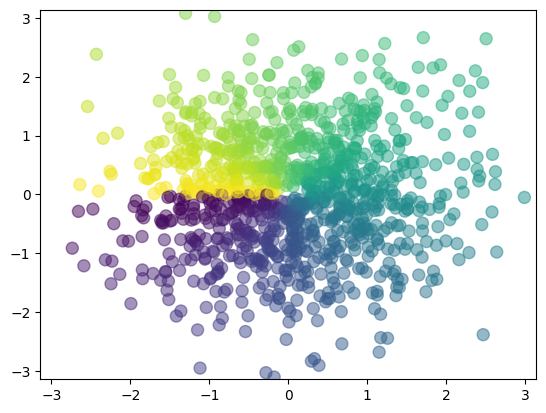

In [ ]:
n = 1024
X = np.random.normal(0, 1, n)
Y = np.random.normal(0, 1, n)
T = np.arctan2(Y, X)

plt.scatter(X, Y, s=75, c=T, alpha=0.5);
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

## Plotting a function of x
To start trying out plotting, let's first define a function to plot:
$$ f(x) = (x - 3) (x - 5) (x - 7) + 85 $$

In [ ]:
def func(x):
    return (x - 3) * (x - 5) * (x - 7) + 85

Next, we plot this function on $  \ x \in [0, 10] $

In [ ]:
import numpy as np

# Calculate plot points:
x = np.linspace(0, 10)

In [ ]:
# Evaluate the function at the plot points
y = func(x)

# Plot graph defined by x/y points
plt.plot(x, y)

NameError: name 'plt' is not defined

## Reading files with numpy
With numpy, we use the loadtxt function to read numerical data.

```txt
10 20 30 
20 30 1
2.2 125 6.45
0.1 20 3.14
```

In [ ]:
np.loadtxt('data/example_data_simple.txt')

There are several options to manage how the file should be read: 
```txt
This is the first line of the file
This is the second line of the file
Below comes the interesting part of the file: 
10 20 30 
20 30 1
2.2 125 6.45
0.1 20 3.14
```

In [ ]:
np.loadtxt('data/example_data.txt', skiprows=3)

array([[1.00e+01, 2.00e+01, 3.00e+01],
       [2.00e+01, 3.00e+01, 1.00e+00],
       [2.20e+00, 1.25e+02, 6.45e+00],
       [1.00e-01, 2.00e+01, 3.14e+00]])

```txt
First 10 20 30 
Second 20 30 1
Third 2.2 125 6.45
Fourth 0.1 20 3.14
```

In [ ]:
np.loadtxt('data/example_data_extra_column.txt', usecols=((1,2,3)))

array([[1.00e+01, 2.00e+01, 3.00e+01],
       [2.00e+01, 3.00e+01, 1.00e+00],
       [2.20e+00, 1.25e+02, 6.45e+00],
       [1.00e-01, 2.00e+01, 3.14e+00]])

```txt
10,20,30 
20,30,1
2.2,125,6.45
0.1,20,3.14
```

In [ ]:
np.loadtxt('data/example_data_comma.txt', delimiter=',')

array([[1.00e+01, 2.00e+01, 3.00e+01],
       [2.00e+01, 3.00e+01, 1.00e+00],
       [2.20e+00, 1.25e+02, 6.45e+00],
       [1.00e-01, 2.00e+01, 3.14e+00]])

# Plot values from the data

Typically we may have a time series of data, consisting of time stamps in the first column and some interesting data in the rest of the columns: e.g.
```txt
t p0 p1
0 0.1 0.2
0.5 0.4 0.33
1.0 0.5 0.66
1.5 0.6 1.3
2.0 0.62 1.70
```

If we do not know about the shape of the data, we load it in as a matrix:

In [ ]:
data = np.loadtxt('data/time_series.txt',skiprows=1)
data.shape

(5, 3)

If we know the shape of the data it is possible to read each column directly to a python object. However, we might need to be careful:

In [86]:
t, p0, p1 = np.loadtxt('data/time_series.txt', skiprows=1)

ValueError: too many values to unpack (expected 3)

In [87]:
t, p0, p1 = np.loadtxt('data/time_series.txt', skiprows=1).transpose()
t,p0,p1

(array([0. , 0.5, 1. , 1.5, 2. ]),
 array([0.1 , 0.4 , 0.5 , 0.6 , 0.62]),
 array([0.2 , 0.33, 0.66, 1.3 , 1.7 ]))

Now it is possible to plot from both to obtain the same result:

In [88]:
plt.plot(t, p0)
plt.plot(data[:,0], data[:,1],'--')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Working with larger data sets
Consider the data in bank_index.csv
```
date,open,high,low,close,volume
2015-01-09 09:15:00+05:30,18845.9,18864.0,18790.2,18815.15,0
2015-01-09 09:30:00+05:30,18815.15,18821.4,18758.5,18771.6,0
...
```

We currently have the tools to load all columns except the date

In [89]:
data = np.loadtxt('data/bank_index.csv', skiprows=1, usecols=(np.arange(1,5)), delimiter=',')

In [90]:
data.shape

(43857, 4)

In [91]:
from datetime import datetime
datestring = "2015-01-09 09:15:00+05:30"
datetime.strptime(datestring, "%Y-%m-%d %H:%M:%S+05:30")


datetime.datetime(2015, 1, 9, 9, 15)

In [ ]:
np.datetime64(datestring)
#important to keep track with time zones, especially with time series when you see that big business have issues with day time savings since of the 1 hour change
#one would think you can hardcore your timezone, but you have to change it everytime 
#always a big issue
#best thing to use pandas to handlel dates 



C:\Users\V\AppData\Local\Temp\ipykernel_7120\2590407879.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  np.datetime64(datestring)


numpy.datetime64('2015-01-09T03:45:00')

In [93]:
time = np.loadtxt('data/bank_index.csv', skiprows=1, usecols=(0,),delimiter=',')#,dtype='datetime64')

ValueError: could not convert string '2015-01-09 09:15:00+05:30' to float64 at row 0, column 1.

In [96]:
time = np.loadtxt('data/bank_index.csv', skiprows=1, usecols=(0,),delimiter=',',dtype='datetime64')

In [97]:
plt.plot(time, data[:,0])
plt.title('Opening NIFTY index per year')
plt.ylabel('Index',fontsize=15)
plt.xlabel('Year', fontsize=15)

Text(0.5, 23.52222222222222, 'Year')

# Exercise 
Use numpy to read and plot data from all columns from the vix-daily dataset (vix-daily_csv.csv) located on GitHub